Link to competition: https://www.kaggle.com/c/fungi-challenge-fgvc-2018/overview

# Preparations

In [17]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [18]:
from fastai.vision import * 
from fastai.metrics import top_k_accuracy
import json
from itertools import groupby

In [19]:
np.random.seed(1991)

How many training examples are processed in one iteration. If you face memory errors, decrease the batch size

In [20]:

batch_size = 64

Which image augmentation tecniques are used for the training data. Play with different options and see how they affect the results.

In [21]:
tfms = None
# tfms = get_transforms()
# tfms...?

The model that is going to be used in the classification task

In [22]:
model = models.resnet34
# model = models.resnet50

The size to be used for progressive resizing

In [23]:
image_size1 = 128
image_size2 = 256

# Loading Data

In [24]:
data_path_str = "data"
train_path_str = "train"
test_path_str = "test"

In [25]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = image_size1,
    ds_tfms = tfms,
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [26]:
data

ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data

# Visualize Data

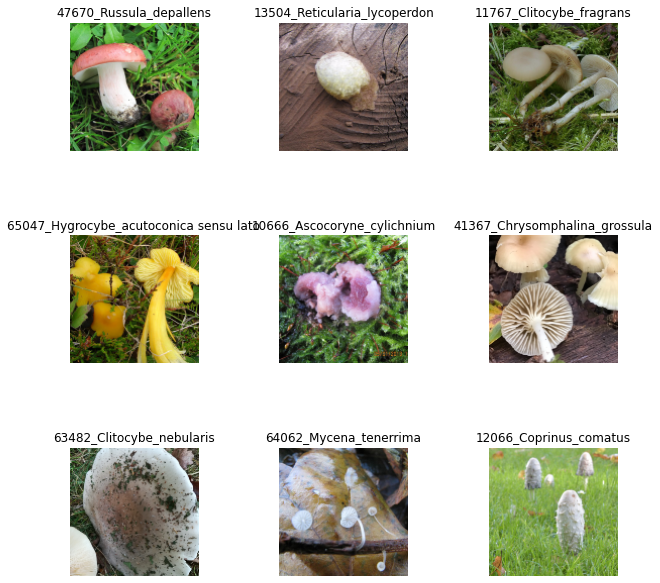

In [11]:
data.show_batch(3, figsize = (9, 9))

Analyzing dataset class frequences

In [12]:
class_labels = [data.y.classes[value] for value in data.y.items]

In [16]:
class_frequences = {key: len(list(group)) for key, group in groupby(class_labels)}

From the plots below we can see that over half of the classes have less than 50 images in them. Getting more images to the underpresented classes could improve the performance significantly.

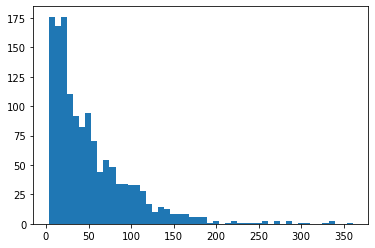

In [17]:
plt.hist(class_frequences.values(), bins = 50)
plt.show()

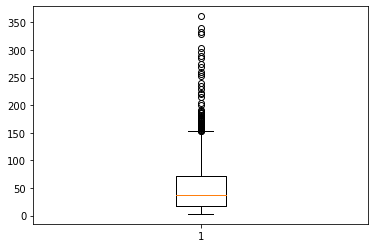

In [18]:
plt.boxplot(class_frequences.values())
plt.show()

# Training the model

We will use as our accuracy metrics top_k_accuracy, as it was the one used in the competition presented in Kaggle.

We will train first re-train only the top most layer of the model

In [27]:
top_k_accuracy_3 = partial(top_k_accuracy, k=3)

In [28]:
learner = cnn_learner(data, model, metrics=top_k_accuracy_3)

In [21]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


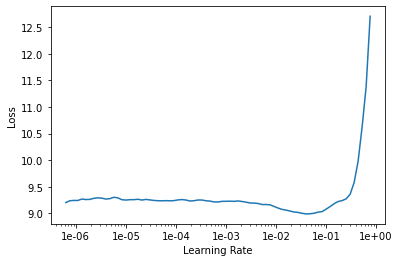

In [22]:
learner.recorder.plot()

In [23]:
lr = 1e-02

In [24]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,5.233247,5.128566,0.187667,11:30
1,4.539595,4.135845,0.346814,12:41
2,3.981825,3.698301,0.424242,07:19


In [29]:
file_name = "_".join([model.__name__, str(image_size1), "stage1"])

In [25]:
learner.save(file_name)

## Fine Tuning

To get the model more specialized in the task of recognizing mushrooms, we will unfreeze the model and train all the layers in the model

In [30]:
learner.load(file_name)

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [31]:
learner.unfreeze()

In [32]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


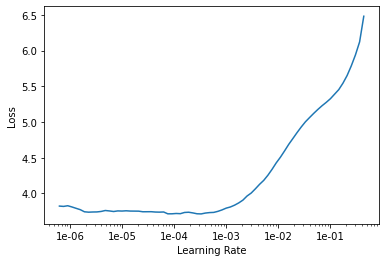

In [33]:
learner.recorder.plot()

In [34]:
lr = slice(1e-6,1e-04)

In [35]:
learner.fit_one_cycle(6, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,3.719376,3.659101,0.430927,11:58
1,3.613052,3.574337,0.446357,06:49
2,3.508628,3.502522,0.457275,06:38
3,3.347982,3.463588,0.464628,06:38
4,3.290114,3.440576,0.468360,06:38
5,3.249714,3.440397,0.467914,06:36


In [36]:
file_name = "_".join([model.__name__, str(image_size1), "stage2"])
learner.save(file_name)

## Progressive Resizing

We use progressive resizing to improve our results from the originals

In [37]:
learner.load(file_name)

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [38]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = image_size2,
    ds_tfms = tfms,
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [39]:
learner.data = data

In [40]:
learner.freeze()

In [41]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


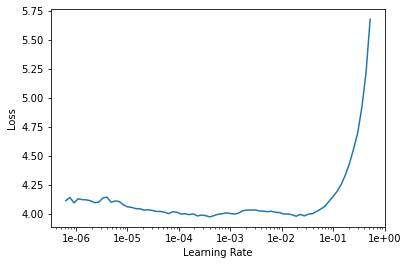

In [42]:
learner.recorder.plot()

In [43]:
lr = 1e-02

In [44]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,4.225386,3.745227,0.408812,10:06
1,3.635183,3.051121,0.539717,10:06
2,3.006013,2.720641,0.598986,09:39


In [45]:
file_name = "_".join([model.__name__, str(image_size2), "stage1"])
learner.save(file_name)

### Fine Tuning

In [46]:
learner.load(file_name)

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
61255_Coprinopsis_stercorea,10235_Amanita_gemmata,19336_Deconica_montana,10266_Amanita_strobiliformis,21143_Tricholoma_scalpturatum
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
learner.unfreeze()

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


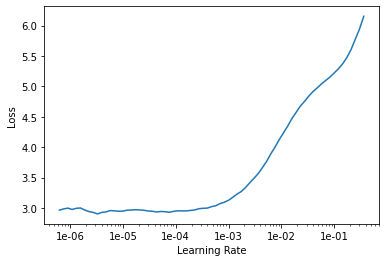

In [23]:
learner.recorder.plot()

In [24]:
lr = slice(1e-6,1e-04)

In [25]:
learner.fit_one_cycle(7, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.966246,2.731215,0.598095,11:26
1,2.915502,2.656915,0.611798,11:23
2,2.857046,2.599371,0.620488,11:14
3,2.825556,2.571108,0.623552,11:34
4,2.776285,2.568284,0.624721,11:26


In [26]:
file_name = "_".join([model.__name__, str(image_size2), "stage2"])
learner.save(file_name)

# Prediction

In [38]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [39]:
pred_classes = [np.array(p).argsort()[-3:][::-1] for p in preds]

In [40]:
pred_classes = [" ".join(p.astype(str) ) for p in pred_classes]

In [41]:
with open("data/test2.json") as json_file:
    data = json.load(json_file)
    files_to_ids = {i["file_name"] : i["id"] for i in data["images"]}

In [42]:
ids = [files_to_ids["test/" + f.name] for f in learner.data.test_ds.items]

In [43]:
pred_classes[:5]

['109 566 119', '269 1279 699', '1033 293 76', '621 1377 1147', '303 1241 67']

In [44]:
ids[:5]

[123772, 42782, 8956, 52044, 114626]

In [45]:
df = pd.DataFrame({"id": ids, "predicted": pred_classes})

In [46]:
df[:5]

,id,predicted
0,123772,109 566 119
1,42782,269 1279 699
2,8956,1033 293 76
3,52044,621 1377 1147
4,114626,303 1241 67


In [47]:
df.to_csv('data/submission2.csv', index=False)

# Scores

1. Initial prediction
    - train_loss: 3.401437
    - valid_loss: 3.261729
    - top_k_accuracy: 0.513369
    - test_score private: 0.69770
    - test_score public: 0.70037
2. Image augmentation, FInetuning and progressive resizing
    - train_loss: 2.776285
    - valid_loss: 2.568284
    - top_k_accuracy: 0.624721
    - test_score private: 0.73210 
    - test_score public: 0.74171